In [1]:
# Setting

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# 'Ffires.csv'

In [2]:
# Data Load - Forest fire Dataset
path = os.getcwd()
df = pd.read_csv(os.path.join(path, 'Ffires.csv'))
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


In [3]:
# Brief EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
## Check NaN
df.isnull().sum()

# no NaN

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [5]:
## To see Dataframe at maximum
pd.set_option('display.max_columns', 50)

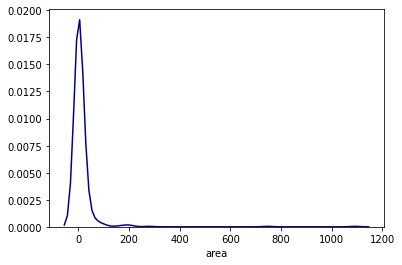

In [6]:
# Feature Enigineering(Data Preprocessing)
# Once take a look at the distribution of the target variable('area'), able see that it is skewed to the right.
sns.distplot(df["area"], color="darkblue", kde=True, hist=False)
plt.show()

In [7]:
## Create a variable after applying log transformation to 'area' for EDA
df['log_area'] = df['area'].map(lambda x: np.log(x) if x > 5 else 0)

In [8]:
## Mapping values to 1 if greater than 5, otherwise 0 
df['area'] = df['area'].map(lambda x: 1 if x > 5 else 0)

In [9]:
## Feature scaling
### The kernel support vector machine highly dependent on the scale unit, so careful pre-processing required
### In the case of continuous variables, standard normalization and min-max normalization needed

def data_scaler_ff(df, col_list):
    """
    The function for standard normalization and min-max normalization
    
    :file: dataset
    :col_list: a list containing names of columns; It should be continuous data
    :return: scaled data
    """
    
    scaler = MinMaxScaler()

    for col in col_list:
        df[col] = (df[col] - np.mean(df[col], axis=0)) / np.std(df[col])
        output = np.array( scaler.fit_transform(df[col].values.reshape(-1, 1)) )
        df[col] = output

    return df

### col_list : a list containing the names of the columns to be preprocessed
col_list = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
df = data_scaler_ff(df=df, col_list=col_list)

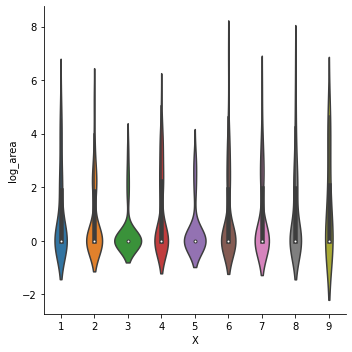

In [10]:
## The relationship between coordinates and 'area' - no big differences among X
sns.catplot(x="X", y="log_area", data=df, orient="v", kind="violin")
plt.show()

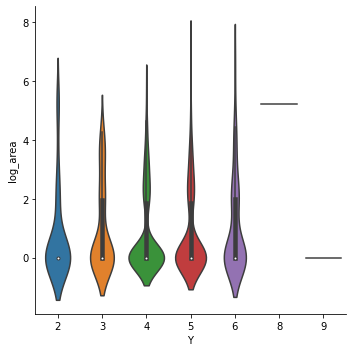

In [11]:
sns.catplot(x="Y", y="log_area", data=df, orient="v", kind="violin")
plt.show()

In [12]:
## Apply only min-max scaling to X and Y columns containing the coordinates
scaler = MinMaxScaler()
df['X'] = scaler.fit_transform(df['X'].values.astype('float64').reshape(-1, 1))
df['Y'] = scaler.fit_transform(df['Y'].values.astype('float64').reshape(-1, 1))

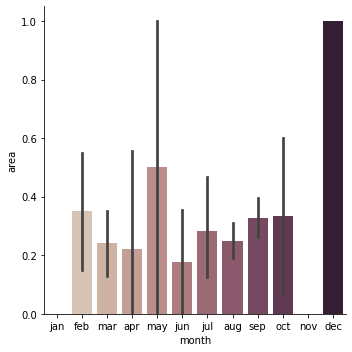

In [13]:
## The relationship between 'month' and 'area'
### Especially, in December
sns.catplot(x="month", y='area', kind="bar", palette="ch:.25", data=df,
order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.show()

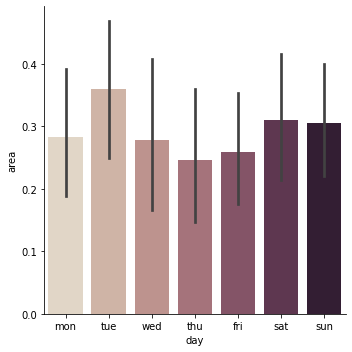

In [14]:
## The relationship between 'day' and 'area'
sns.catplot(x="day", y='area', kind="bar", palette="ch:.25", data=df,
order=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
plt.show()

In [17]:
## Mapping ('month', 'day') - Encoding Categorical Variables
month_mapping = {'jan':0, 'feb':1/11, 'mar':2/11, 'apr':3/11, 'may':4/11, 'jun':5/11,
'jul':6/11, 'aug':7/11, 'sep':8/11, 'oct':9/11, 'nov':10/11, 'dec':1}
day_mapping = {'mon':0, 'tue':1/6, 'wed':2/6, 'thu':3/6, 'fri':4/6, 'sat':5/6, 'sun':1}

df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,0.750,0.428571,0.181818,0.666667,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,0.00000,0,0.0
1,0.750,0.285714,0.818182,0.166667,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,0.00000,0,0.0
2,0.750,0.285714,0.818182,0.833333,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,0.00000,0,0.0
3,0.875,0.571429,0.181818,0.666667,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,0.03125,0,0.0
4,0.875,0.571429,0.181818,1.000000,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,0.00000,0,0.0


In [18]:
# Train/Test
## In this data, will focus on the Gaussian kernel and tuning
X = df.drop(['area', 'log_area'], axis=1).values
Y = df['area'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)
print("Length of X_train: ", len(X_train)) # 413
print("Length of X_test: ", len(X_test)) # 104
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svm = SVC(kernel='rbf')
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)


Length of X_train:  413
Length of X_test:  104


0.7307692307692307

In [21]:
# Results
print('Best Parameters : ', grid.best_params_)
print('Train Accuracy : ', grid.score(X_train, Y_train))
print('Test Accuracy : ', grid.score(X_test, Y_test))
## Best Parameters {'C': 10, 'gamma': 0.1}
## Train Accuracy 72.63%
## Test Accuracy 73.07%

Best Parameters :  {'C': 100, 'gamma': 0.1}
Train Accuracy :  0.7263922518159807
Test Accuracy :  0.7307692307692307


# 'SN_ad.csv'

In [22]:
# Data Load - Target variable needed to be set as 'Purchased'
sn = pd.read_csv(os.path.join(path, 'SN_ad.csv'))
sn.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [23]:
# Brief EDA
sn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [24]:
## Check NaN
sn.isnull().sum()

# no NaN

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [25]:
# Feature Enigineering(Data Preprocessing)
## Drop 'USER ID' column
sn.drop('User ID', axis=1, inplace=True)

In [26]:
## Mapping 'Gender' - Encoding Categorical Variables
sn['Gender'] = sn['Gender'].map({'Male':0, 'Female':1})

In [28]:
## Feature scaling
### The kernel support vector machine highly dependent on the scale unit, so careful pre-processing required
### In the case of continuous variables, standard normalization and min-max normalization needed
### "EstimatedSalary" -> "ES"
sn = sn.rename(columns={"EstimatedSalary":"ES"}, inplace=False)

def data_scaler_sn(sn):
    """
    The function for standard normalization and min-max normalization

    :sn: dataset
    :return: scaled data
    """
    # Normalizing
    sn['Age'] = (sn['Age'] - np.mean(sn['Age'], axis=0)) / np.std(sn['Age'])
    sn['ES'] = (sn['ES'] - np.mean(sn['ES'], axis=0)) / np.std(sn['ES'])

    # MinMaxScaling
    scaler = MinMaxScaler()
    Age = np.array( scaler.fit_transform(sn['Age'].values.reshape(-1, 1)) )
    ES = np.array( scaler.fit_transform(sn['ES'].values.reshape(-1, 1)) )
    
    return Age, ES

Age, ES = data_scaler_sn(sn)

sn['Age'] = Age
sn['ES'] = ES

sn.head(5)

,Gender,Age,ES,Purchased
0,0,0.023810,0.029630,0
1,0,0.404762,0.037037,0
2,1,0.190476,0.207407,0
3,1,0.214286,0.311111,0
4,0,0.023810,0.451852,0


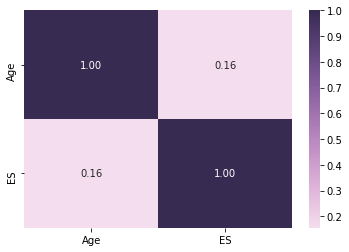

In [29]:
## The relationship between 'Age' and 'ES' - no significant relationship
cmap = sns.cubehelix_palette(n_colors=3, start=0, rot=0.2, light=0.9, dark=0.2, as_cmap=True)
sns.heatmap(sn[['Age', 'ES']].corr(), annot=True, fmt="0.2f", cmap=cmap)
plt.show()

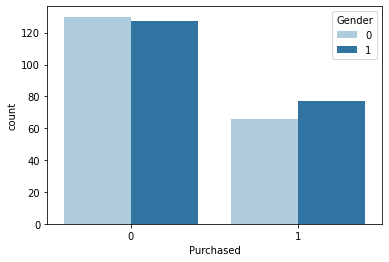

In [30]:
## Check the effect of each variable on purchases through a graph
## Gender: Female(1) shows a higher purchase rate
sns.countplot(x='Purchased', hue='Gender', data=sn, palette=sns.color_palette("Paired", 2))
plt.show()

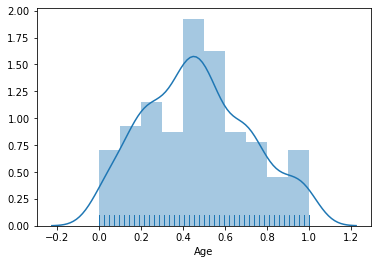

In [31]:
## Age
sns.distplot(sn[('Age')], hist=True, bins=10, kde=True, rug=True)
plt.show() # similar to the normal distribution.

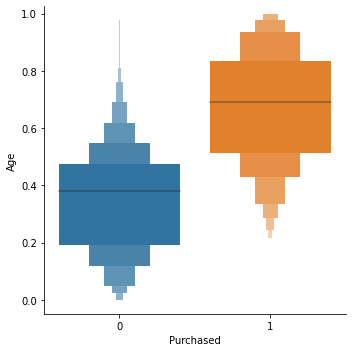

In [32]:
sns.catplot(x="Purchased", y="Age", kind="boxen", data=sn)
plt.show() # the older they are, the more they purchased

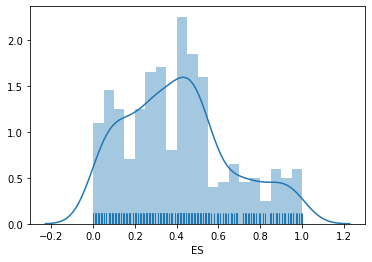

In [33]:
## ES
sns.distplot(sn[('ES')], hist=True, bins=20, kde=True, rug=True)
plt.show() # the proportion of low-middle income groups is higher

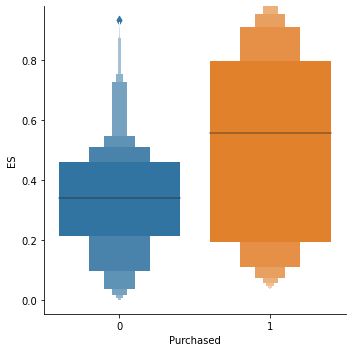

In [34]:
sns.catplot(x="Purchased", y="ES", kind="boxen", data=sn)
plt.show() # definitely, the richer they are, the more they spend money

In [35]:
## Dataset for Train/Test
X = sn[['Gender', 'Age', 'ES']].values
Y = sn['Purchased'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("Length of X_train: ", len(X_train)) # 320
print("Length of X_test: ", len(X_test)) # 80

Length of X_train:  320
Length of X_test:  80


In [36]:
# Train/Test

# Will fix random_state for kernel comparison
# No need to load the scaler since scaling was performed in advance
# Once take a look at the number of purchased labels, 0: 257 and 1:143 are not that unbalanced
# Therefore, will use accuracy for the performance indicator

sn['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

In [37]:
## Due to the high volume of learning when comparing kernels, will compare them simply
## Poly kernel - too slow - excluded

## Linear kernel
param_grid = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.01, 0.1, 1, 10, 100]}
svm = SVC(kernel='linear', random_state=0)
grid1 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy')
grid1.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(kernel='linear', random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [38]:
## Gaussian kernel
param_grid = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.01, 0.1, 1, 10, 100]}
svm = SVC(kernel='rbf', random_state=0)
grid2 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy')
grid2.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [39]:
## Sigmoid kernel
param_grid = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.01, 0.1, 1, 10, 100]}
svm = SVC(kernel='sigmoid', random_state=0)
grid3 = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy')
grid3.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(kernel='sigmoid', random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [46]:
# Results
print('Kernel : ', 'Linear kernel', 'Gaussian kernel', 'Sigmoid kernel')
print('Best Parameters : ', grid1.best_params_, grid2.best_params_, grid3.best_params_)
print('Train Accuracy : ', grid1.score(X_train, Y_train), grid2.score(X_train, Y_train), grid3.score(X_train, Y_train))
print('Test Accuracy : ', grid1.score(X_test, Y_test), grid2.score(X_test, Y_test), grid3.score(X_test, Y_test))

Kernel :  Linear kernel Gaussian kernel Sigmoid kernel
Best Parameters :  {'C': 10, 'gamma': 0.01} {'C': 100, 'gamma': 1} {'C': 100, 'gamma': 0.1}
Train Accuracy :  0.834375 0.909375 0.840625
Test Accuracy :  0.8 0.9125 0.8
